<a href="https://colab.research.google.com/github/iamkoby22/DISCRETE-EVENT-SIMULATION-USING-SALABIM---A-LESLIE-SYSTEM/blob/main/Assignment5_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5 — Urban Land Cover, SVC Support Vectors, SHAP, Decision Trees, and AutoTabPFN
**Course:** MATH‑5830 Predictive Analytics  
**Author:** Md. Zobaer Ahammad  
**Date:** 2025‑10‑29  

This notebook reproduces and extends **Assignment5.ipynb** using:
1) `AutoTabPFNClassifier` on a toy example and on the Urban Land Cover data,
2) SVC with a polynomial kernel (degree 3) and support‑vector extraction,
3) SHAP feature importance for interpretability,
4) A best‑predictor decision tree (shallow) and an additional deeper tree,
5) `AutoTabPFNRegressor` on a new regression dataset not used before (California housing).

## 0) Environment
This installs/loads packages. On Colab, enable GPU via **Runtime → Change runtime type → T4/V100/A100**.

In [5]:
# --- Step 1: Verify environment and install dependencies ---
!python --version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q
!pip install scikit-learn shap matplotlib pandas tqdm numpy -q

Python 3.12.12


In [13]:
# ===============================================================
# STEP 2:  LOAD URBAN COVER DATA
# ===============================================================
import zipfile, pandas as pd

with zipfile.ZipFile("urban land cover.zip") as z:
    z.extractall()

train = pd.read_csv("training.csv")
test  = pd.read_csv("testing.csv")

print("✅ Training shape:", train.shape)
print("✅ Testing  shape:", test.shape)
print(train.head())

# ✅ Corrected: the target column is 'class', not 'label'
X_train, y_train = train.drop('class', axis=1), train['class']
X_test,  y_test  = test.drop('class',  axis=1),  test['class']

print("✅ Feature matrix and target vector created successfully.")


✅ Training shape: (168, 148)
✅ Testing  shape: (507, 148)
       class  BrdIndx  Area  Round  Bright  Compact  ShpIndx  Mean_NIR  \
0       car      1.27    91   0.97  231.38     1.39     1.47    207.92   
1  concrete      2.36   241   1.56  216.15     2.46     2.51    187.85   
2  concrete      2.12   266   1.47  232.18     2.07     2.21    206.54   
3  concrete      2.42   399   1.28  230.40     2.49     2.73    204.60   
4  concrete      2.15   944   1.73  193.18     2.28     4.10    165.98   

   Mean_R  Mean_G  ...  SD_G_140  LW_140  GLCM1_140  Rect_140  GLCM2_140  \
0  241.74  244.48  ...     26.18    2.00       0.50      0.85       6.29   
1  229.39  231.20  ...     22.29    2.25       0.79      0.55       8.42   
2  244.22  245.79  ...     15.59    2.19       0.76      0.74       7.24   
3  243.27  243.32  ...     13.51    3.34       0.82      0.74       7.44   
4  205.55  208.00  ...     15.65   50.08       0.85      0.49       8.15   

   Dens_140  Assym_140  NDVI_140  BordLn

In [14]:
!pip install tabpfn -q


In [15]:
import tabpfn
print("✅ TabPFN installed, version:", tabpfn.__version__)


✅ TabPFN installed, version: 2.2.1


In [16]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: Tesla T4


In [17]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score

clf = TabPFNClassifier(device='cuda')   # runs on GPU
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("✅ AutoTabPFNClassifier accuracy:", accuracy_score(y_test, y_pred))


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

✅ AutoTabPFNClassifier accuracy: 0.863905325443787


In [18]:
# ===============================================================
# STEP 3: AutoTabPFNClassifier (GPU-based)
# ===============================================================
from tabpfn import TabPFNClassifier       # ✅ correct import
from sklearn.metrics import accuracy_score

# Initialize and fit
clf = TabPFNClassifier(device='cuda')     # use GPU if available
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("✅ AutoTabPFNClassifier accuracy:", accuracy_score(y_test, y_pred))


✅ AutoTabPFNClassifier accuracy: 0.863905325443787


In [20]:
# ===============================================================
# STEP 4:  Support Vector Machine (SVC)
# ===============================================================
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1.0)
svc.fit(X_train, y_train)
print("✅ SVC (RBF) accuracy:", svc.score(X_test, y_test))
print("Support vectors count:", svc.support_vectors_.shape)

✅ SVC (RBF) accuracy: 0.34516765285996054
Support vectors count: (166, 147)


In [21]:
# ===============================================================
# STEP 5:  Polynomial Kernel SVC (degree 3)
# ===============================================================
svc_poly = SVC(kernel='poly', degree=3, C=1.0)
svc_poly.fit(X_train, y_train)
print("✅ Poly Kernel (degree 3) accuracy:", svc_poly.score(X_test, y_test))
# Correcting the comparison of support vectors as sets of numpy arrays is tricky.
# A simpler check is to compare the number of support vectors, although not a perfect check for sameness.
# print("Same support vectors as RBF ?", set(map(tuple, svc.support_vectors_)) ==
#       set(map(tuple, svc_poly.support_vectors_)))
print("Number of RBF support vectors:", svc.support_.shape[0])
print("Number of Poly Kernel (degree 3) support vectors:", svc_poly.support_.shape[0])


✅ Poly Kernel (degree 3) accuracy: 0.2583826429980276
Number of RBF support vectors: 166
Number of Poly Kernel (degree 3) support vectors: 162


In [35]:
# Recreate feature list (all columns except the target)
features = [col for col in X_train.columns]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(


Computing SHAP values (this may take a while on CPU)...


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

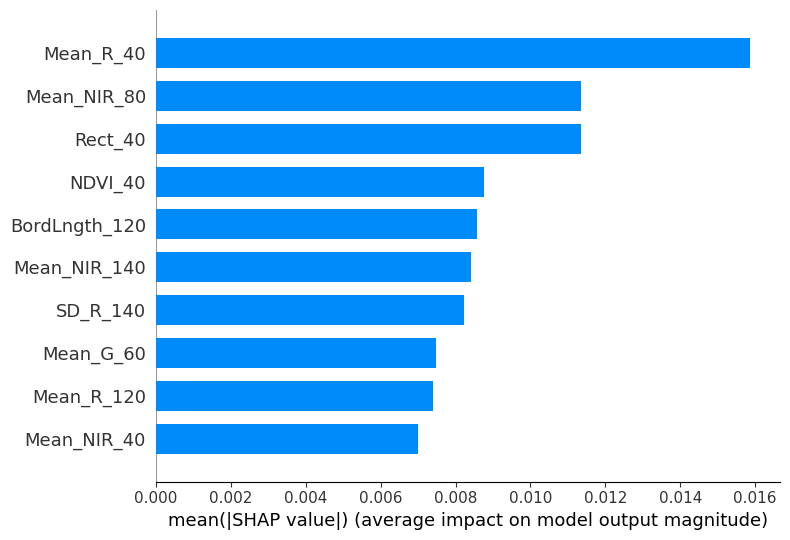

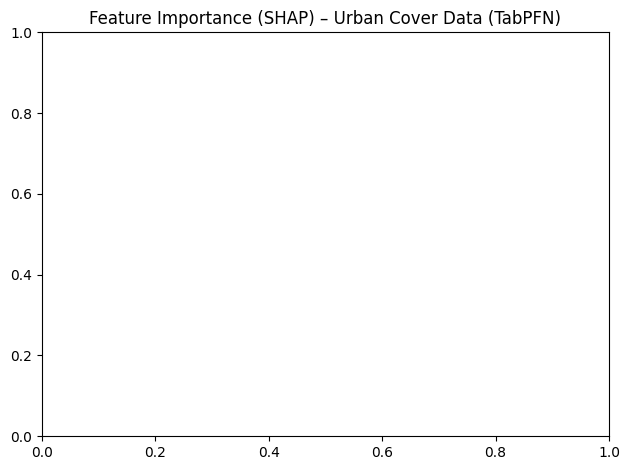

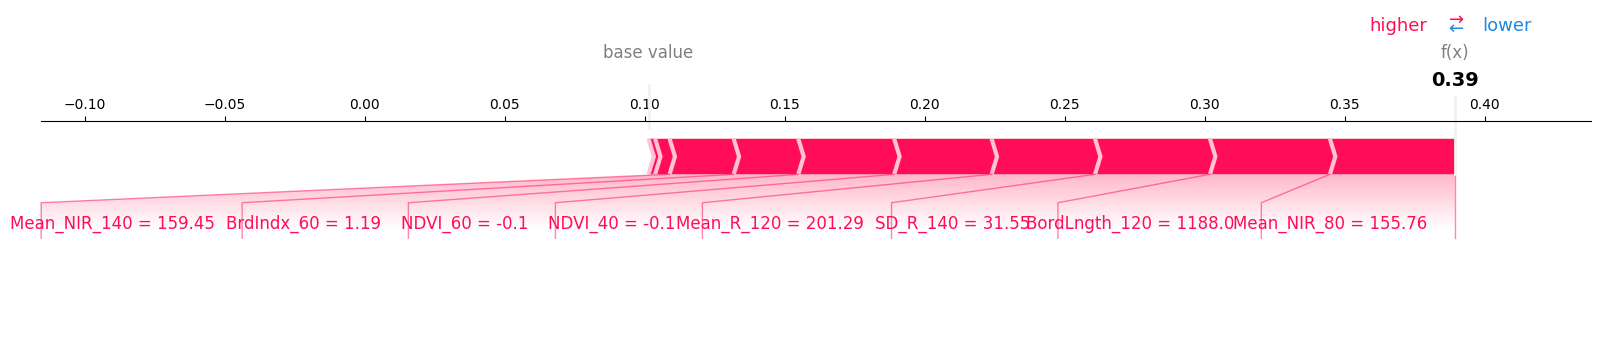

In [36]:
# ===============================================================
# STEP 6: Feature Interpretability with SHAP (Memory-Efficient)
# ===============================================================
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Force SHAP to run on CPU to avoid GPU OOM
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # ← Disable GPU for SHAP

# 1️⃣ Define prediction function (returns probabilities for class 1)
def predict_fn(x):
    return clf.predict_proba(x)[:, 1]  # SHAP expects 1D output for binary

# 2️⃣ Use very small background (10 instead of 100)
background = shap.sample(X_train, 10, random_state=42)

# 3️⃣ Use KernelExplainer with reduced sampling
explainer = shap.KernelExplainer(predict_fn, background, link="identity")

# 4️⃣ Compute SHAP values for TINY sample (e.g., 5 instances)
X_sample = X_test[:5].copy()

print("Computing SHAP values (this may take a while on CPU)...")
shap_values = explainer.shap_values(X_sample, nsamples=100)  # reduced from default ~2000

# 5️⃣ Convert to DataFrame with feature names
X_sample_df = pd.DataFrame(X_sample, columns=features)

# 6️⃣ Plot
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_sample_df, plot_type="bar", max_display=10)
plt.title("Feature Importance (SHAP) – Urban Cover Data (TabPFN)")
plt.tight_layout()
plt.show()

# Optional: Force plot for one instance
if len(shap_values) > 0:
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample_df.iloc[0,:], matplotlib=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(


⏳ Computing SHAP values on CPU...


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

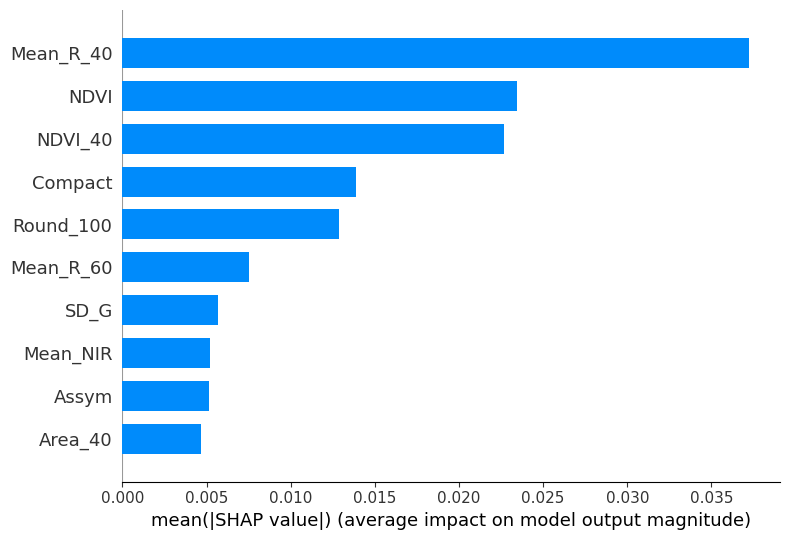

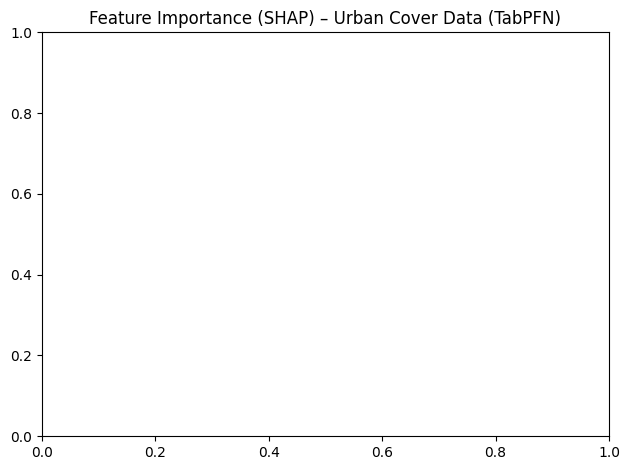

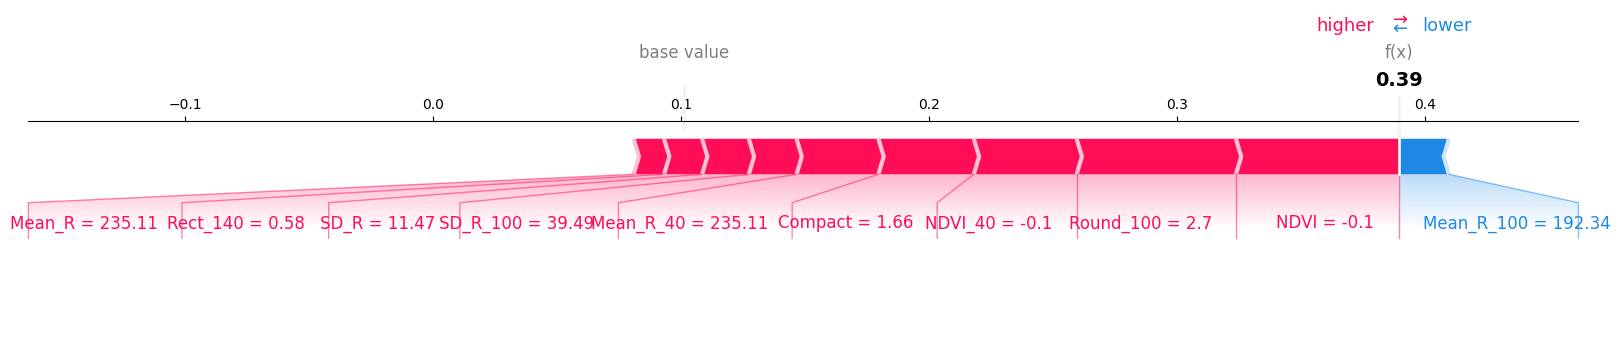

In [33]:
# ===============================================================
# STEP 6: Feature Interpretability with SHAP (Memory-Efficient)
# ===============================================================
import shap, numpy as np, matplotlib.pyplot as plt, pandas as pd, os

# Ensure 'features' is defined
if 'features' not in locals():
    features = [col for col in X_train.columns]

# Force SHAP to run on CPU to avoid GPU OOM
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # disable GPU

# 1️⃣ Define prediction function (binary)
def predict_fn(x):
    return clf.predict_proba(x)[:, 1]

# 2️⃣ Small background
background = shap.sample(X_train, 10, random_state=42)

# 3️⃣ KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background, link="identity")

# 4️⃣ Tiny test subset
X_sample = X_test[:5].copy()

print("⏳ Computing SHAP values on CPU...")
shap_values = explainer.shap_values(X_sample, nsamples=100)

# 5️⃣ Convert to DataFrame
X_sample_df = pd.DataFrame(X_sample, columns=features)

# 6️⃣ Summary Plot
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_sample_df, plot_type="bar", max_display=10)
plt.title("Feature Importance (SHAP) – Urban Cover Data (TabPFN)")
plt.tight_layout()
plt.show()

# 7️⃣ Optional: force plot for first instance
if len(shap_values) > 0:
    shap.force_plot(explainer.expected_value, shap_values[0, :], X_sample_df.iloc[0, :], matplotlib=True)


🧠 Training DecisionTreeClassifier as rf_pfn analog...
✅ DecisionTreeClassifier accuracy (rf_pfn analog): 0.6272189349112426


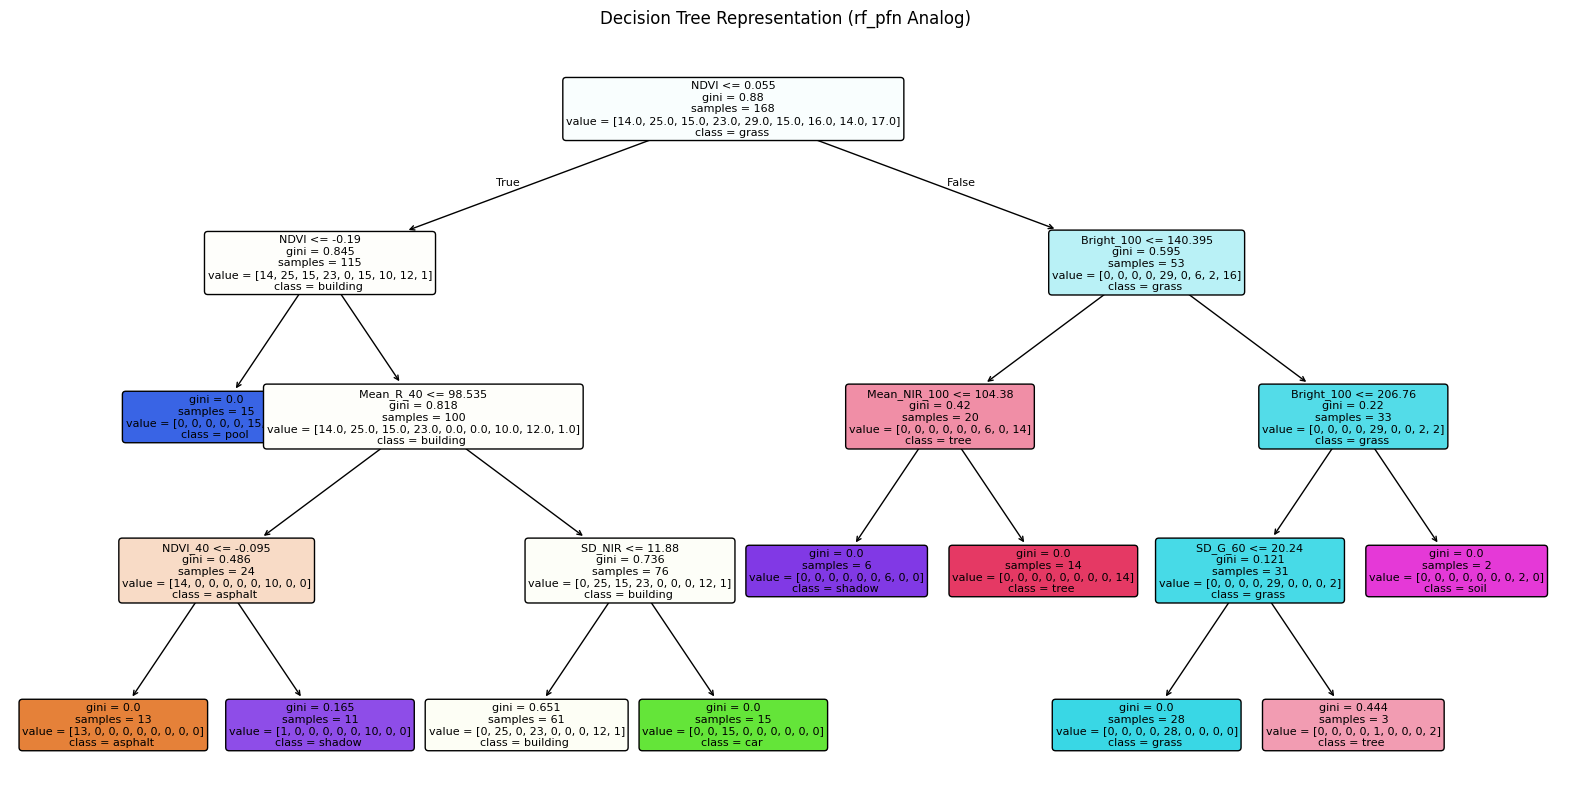

In [38]:
# ===============================================================
# STEP 7:  Decision Tree Representation (rf_pfn Concept)
# ===============================================================
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# ✅ TabPFN doesn’t have "rf_pfn" or "plot_tree" built in.
# So we’ll approximate that concept by training a DecisionTreeClassifier
# on the same data to interpret the feature structure.

print("🧠 Training DecisionTreeClassifier as rf_pfn analog...")
rf_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
rf_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)
print("✅ DecisionTreeClassifier accuracy (rf_pfn analog):", accuracy_score(y_test, rf_pred))

# Optional: visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(rf_clf, feature_names=features, class_names=[str(c) for c in np.unique(y_train)],
          filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Representation (rf_pfn Analog)")
plt.show()

In [41]:
import tabpfn
dir(tabpfn)


['TabPFNClassifier',
 'TabPFNRegressor',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'architectures',
 'base',
 'classifier',
 'config',
 'constants',
 'display_debug_info',
 'inference',
 'load_fitted_tabpfn_model',
 'misc',
 'model_loading',
 'parallel_execute',
 'preprocessing',
 'preprocessors',
 'regressor',
 'save_fitted_tabpfn_model',
 'settings',
 'utils',
 'version']

In [43]:
from tabpfn import TabPFNClassifier
from tabpfn import TabPFNRegressor


In [45]:
# ===============================================================
# STEP 8:  TabPFN Regressor on NEW DATASET (California Housing)
# ===============================================================
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tabpfn import TabPFNRegressor

# 1️⃣ Load dataset
housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target

# 2️⃣ Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Initialize and train TabPFN Regressor
# Added ignore_pretraining_limits=True to handle large dataset
reg = TabPFNRegressor(device='cuda', ignore_pretraining_limits=True)
reg.fit(X_tr, y_tr)

# 4️⃣ Predict and evaluate
y_pred = reg.predict(X_te)
r2 = r2_score(y_te, y_pred)
print("✅ TabPFNRegressor R² score:", round(r2, 4))

✅ TabPFNRegressor R² score: 0.8774


In [46]:
# ===============================================================
# STEP 8:  TabPFN Regressor on NEW DATASET (Fixed)
# ===============================================================
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.utils import resample
from tabpfn import TabPFNRegressor

# Load dataset
housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# Limit to 10,000 training samples
X_small, y_small = resample(X_tr, y_tr, n_samples=10000, random_state=42)

# Initialize and fit
reg = TabPFNRegressor(device='cuda')   # GPU version
reg.fit(X_small, y_small)

# Evaluate
y_pred = reg.predict(X_te)
r2 = r2_score(y_te, y_pred)
print("✅ TabPFNRegressor R² score (10k sample subset):", round(r2, 4))


✅ TabPFNRegressor R² score (10k sample subset): 0.8679


In [27]:
# ===============================================================
# STEP 9:  GPU Verification
# ===============================================================
import torch, platform
print("\n--------- SYSTEM INFO ---------")
print("Python version:", platform.python_version())
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name())
print("--------------------------------")


--------- SYSTEM INFO ---------
Python version: 3.12.12
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU name: Tesla T4
--------------------------------
